In [26]:
import requests
import json

In [27]:
unfiltered_endpoint="/api/get/investment"

url=f"http://localhost:8080{unfiltered_endpoint}"

In [28]:
body=requests.get(url).json()

In [29]:
import pandas as pd
df=pd.DataFrame(body)

In [30]:
df.drop(columns=["_id","__v"],inplace=True, errors='ignore')
# df.head(5)

In [31]:
df["Date_Of_Ownership"]=pd.to_datetime(df["Date_Of_Ownership"])
# df.head(5)

In [32]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns

PREDICTION MODEL

In [34]:
from prophet import Prophet

ModuleNotFoundError: No module named 'prophet'

In [35]:
df_to_predict= df.loc[(df['Company']== Company_Name) & (df['Company_Investor']== Company_Investor_Name) & (df['Domicile']== Domicile_Name) ]
df_to_predict.head(5)

NameError: name 'Company_Name' is not defined

In [22]:
df_to_predict=df_to_predict.set_index(['Date_Of_Ownership'])
df_to_predict=df_to_predict.sort_index()
df_to_predict.index

DatetimeIndex(['2024-01-01 00:00:00+00:00', '2024-01-02 00:00:00+00:00',
               '2024-01-03 00:00:00+00:00', '2024-01-04 00:00:00+00:00',
               '2024-01-05 00:00:00+00:00', '2024-01-06 00:00:00+00:00',
               '2024-01-07 00:00:00+00:00', '2024-01-08 00:00:00+00:00',
               '2024-01-09 00:00:00+00:00', '2024-01-10 00:00:00+00:00',
               ...
               '2024-12-22 00:00:00+00:00', '2024-12-23 00:00:00+00:00',
               '2024-12-24 00:00:00+00:00', '2024-12-25 00:00:00+00:00',
               '2024-12-26 00:00:00+00:00', '2024-12-27 00:00:00+00:00',
               '2024-12-28 00:00:00+00:00', '2024-12-29 00:00:00+00:00',
               '2024-12-30 00:00:00+00:00', '2024-12-31 00:00:00+00:00'],
              dtype='datetime64[ns, UTC]', name='Date_Of_Ownership', length=365, freq=None)

In [23]:
df_to_predict=df_to_predict.reset_index()

In [24]:
df_to_predict=df_to_predict.drop(["Company","Company_Investor","Domicile","Business","Percentage_Ownership","Year_Of_Operation"], axis=1)
df_to_predict.head(5)

,Date_Of_Ownership,Revenue,Expense,Ebida,Tax_Investment,Price_Asset,Price_Liability,Equity,COGS
0,2024-01-01 00:00:00+00:00,3850349,2782029,940217,188043,1543061,932151,610910,128103
1,2024-01-02 00:00:00+00:00,651018,428874,143279,28655,7137050,1127641,6009409,78865
2,2024-01-03 00:00:00+00:00,4075525,1174651,2794090,558818,4427399,2756399,1671000,106784
3,2024-01-04 00:00:00+00:00,3666784,2455174,1062197,212439,1971862,976827,995035,149413
4,2024-01-05 00:00:00+00:00,1285326,980327,141420,28284,2298142,1020891,1277251,163579


In [25]:
df_to_predict=df_to_predict.dropna()
df_to_predict.isna().count()

Date_Of_Ownership    365
Revenue              365
Expense              365
Ebida                365
Tax_Investment       365
Price_Asset          365
Price_Liability      365
Equity               365
COGS                 365
dtype: int64

In [26]:
df_to_predict['Date_Of_Ownership'] = pd.to_datetime(df_to_predict['Date_Of_Ownership']).dt.tz_localize(None)
df_to_predict2=df_to_predict.copy()

In [27]:
df_to_predict.head()

,Date_Of_Ownership,Revenue,Expense,Ebida,Tax_Investment,Price_Asset,Price_Liability,Equity,COGS
0,2024-01-01,3850349,2782029,940217,188043,1543061,932151,610910,128103
1,2024-01-02,651018,428874,143279,28655,7137050,1127641,6009409,78865
2,2024-01-03,4075525,1174651,2794090,558818,4427399,2756399,1671000,106784
3,2024-01-04,3666784,2455174,1062197,212439,1971862,976827,995035,149413
4,2024-01-05,1285326,980327,141420,28284,2298142,1020891,1277251,163579


In [28]:
days_to_predict = 30

In [29]:
forecast_results = {}

columns_to_forecast= ['Revenue','Expense','Ebida','Tax_Investment','Price_Asset','Price_Liability','Equity','COGS']

for column in columns_to_forecast:
    # Prepare the data for Prophet
    data = df[['Date_Of_Ownership', column]].rename(columns={'Date_Of_Ownership': 'ds', column: 'y'})
    data['ds'] = pd.to_datetime(data['ds']).dt.tz_localize(None)
    cap_value = data['y'].quantile(0.95)
    data['cap'] = cap_value
    
    model= Prophet(growth='logistic', yearly_seasonality=False, weekly_seasonality=True,daily_seasonality=True)
    # model.add_seasonality(name='quarterly', period=30, fourier_order=5)
    model.fit(data)
    
    # Make future dataframe for the next 90 days
    future = model.make_future_dataframe(periods=days_to_predict, include_history=False)
    future['cap']=cap_value
    
    # Forecast the data
    forecast = model.predict(future)
    
    # Store the results
    forecast_results[column] = forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']]


00:09:26 - cmdstanpy - INFO - Chain [1] start processing
00:09:27 - cmdstanpy - INFO - Chain [1] done processing
00:09:28 - cmdstanpy - INFO - Chain [1] start processing
00:09:28 - cmdstanpy - INFO - Chain [1] done processing
00:09:29 - cmdstanpy - INFO - Chain [1] start processing
00:09:29 - cmdstanpy - INFO - Chain [1] done processing
00:09:30 - cmdstanpy - INFO - Chain [1] start processing
00:09:30 - cmdstanpy - INFO - Chain [1] done processing
00:09:30 - cmdstanpy - INFO - Chain [1] start processing
00:09:31 - cmdstanpy - INFO - Chain [1] done processing
00:09:32 - cmdstanpy - INFO - Chain [1] start processing
00:09:32 - cmdstanpy - INFO - Chain [1] done processing
00:09:32 - cmdstanpy - INFO - Chain [1] start processing
00:09:33 - cmdstanpy - INFO - Chain [1] done processing
00:09:33 - cmdstanpy - INFO - Chain [1] start processing
00:09:33 - cmdstanpy - INFO - Chain [1] done processing


In [30]:
# Combine forecasts into a single dataframe
combined_forecast = pd.DataFrame({'ds': forecast_results[columns_to_forecast[0]]['ds']})

for column in columns_to_forecast:
    col_forecast = forecast_results[column].rename(columns={
        'yhat': f'{column}_forecast',
        'yhat_lower': f'{column}_lower',
        'yhat_upper': f'{column}_upper'
    })
    combined_forecast = combined_forecast.merge(col_forecast, on='ds')

# Save or view the combined forecast
combined_forecast.head()


,ds,Revenue_forecast,Revenue_lower,Revenue_upper,Expense_forecast,Expense_lower,Expense_upper,Ebida_forecast,Ebida_lower,Ebida_upper,...,Price_Asset_upper,Price_Liability_forecast,Price_Liability_lower,Price_Liability_upper,Equity_forecast,Equity_lower,Equity_upper,COGS_forecast,COGS_lower,COGS_upper
0,2025-01-01,2.624794e+06,913319.454168,4.293083e+06,1.071878e+06,-88310.762383,2.162817e+06,1.298795e+06,26169.145247,2.659517e+06,...,8.325359e+06,1.799515e+06,187756.166621,3.515708e+06,3.748632e+06,1.367253e+06,6.308541e+06,140984.556950,88364.332332,195435.677716
1,2025-01-02,2.506832e+06,824093.767462,4.211697e+06,9.788655e+05,-119420.872433,2.095499e+06,1.279369e+06,-40505.190189,2.613740e+06,...,8.821103e+06,2.300720e+06,710060.392195,3.885196e+06,3.754515e+06,1.187420e+06,6.176691e+06,141156.384594,82506.297931,193046.506386
2,2025-01-03,2.374056e+06,819339.820664,4.021677e+06,1.218151e+06,64095.844958,2.499506e+06,8.928158e+05,-480410.750674,2.236121e+06,...,8.674490e+06,2.036586e+06,271008.425006,3.654193e+06,3.951604e+06,1.387611e+06,6.643589e+06,145447.565457,94651.412360,196493.236910
3,2025-01-04,2.303879e+06,509820.734395,3.895366e+06,1.236750e+06,94130.831956,2.496175e+06,8.075119e+05,-513280.500143,2.210721e+06,...,8.637817e+06,1.920855e+06,269225.113703,3.653208e+06,4.000211e+06,1.429039e+06,6.747402e+06,141490.585800,86269.572459,198126.001273
4,2025-01-05,2.226668e+06,494617.202233,3.889215e+06,9.993490e+05,-34707.575545,2.132083e+06,9.730704e+05,-333638.856505,2.349793e+06,...,8.352557e+06,1.966949e+06,403195.882250,3.599112e+06,3.654473e+06,1.201948e+06,6.231741e+06,145145.890306,92303.210420,202752.274264


../images


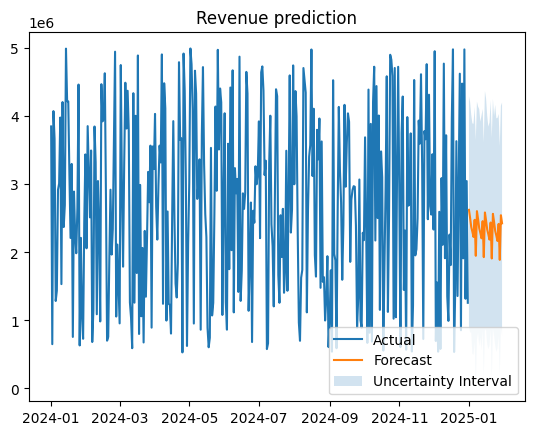

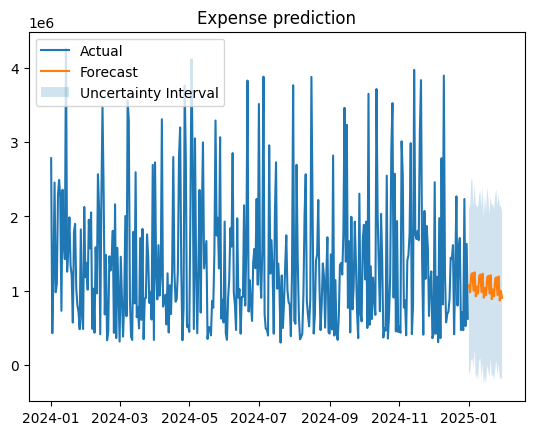

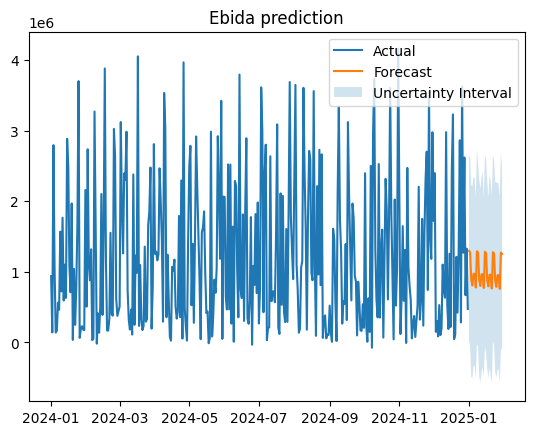

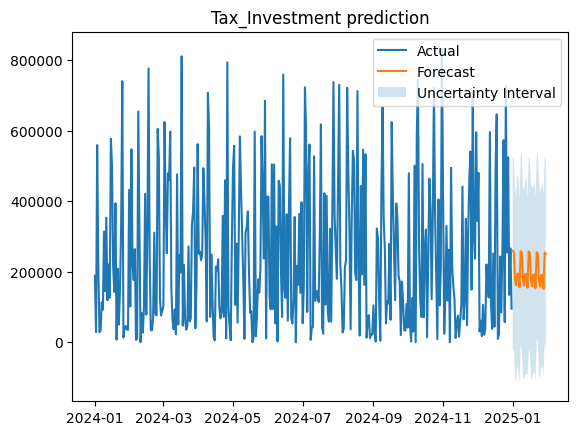

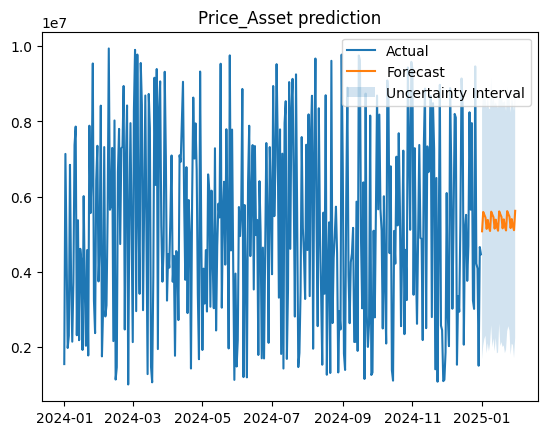

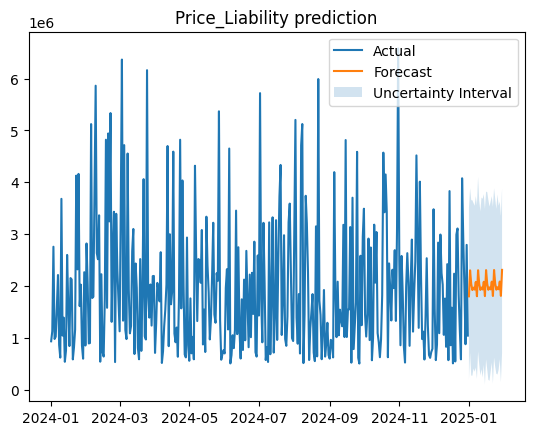

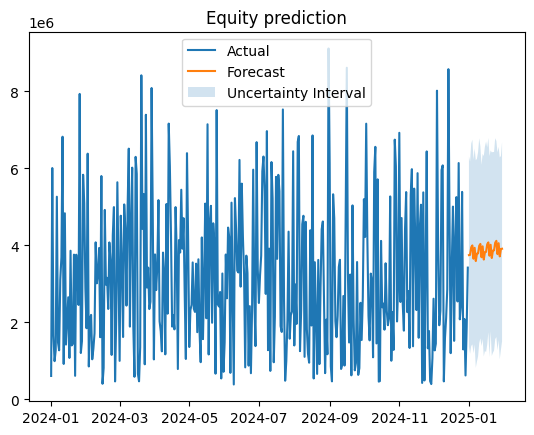

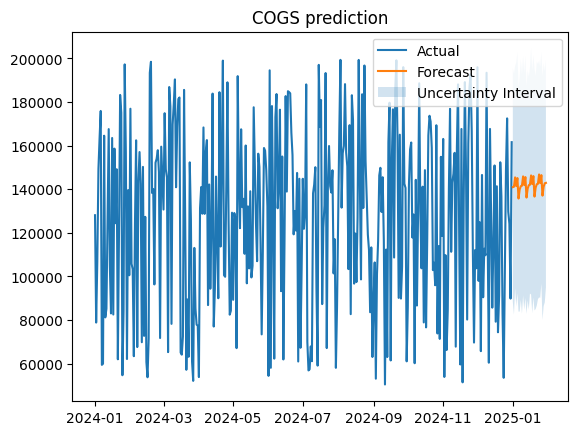

<Figure size 640x480 with 0 Axes>

In [ ]:
import matplotlib.pyplot as plt
import os

images_dir = '../images'
print(images_dir)

if not os.path.exists(images_dir):
    os.makedirs(images_dir)

# Example for a single column
for column in columns_to_forecast:
    plt.plot(df_to_predict['Date_Of_Ownership'], df_to_predict[column], label='Actual')
    plt.plot(forecast_results[column]['ds'], forecast_results[column]['yhat'], label='Forecast')
    plt.fill_between(forecast_results[column]['ds'], forecast_results[column]['yhat_lower'], forecast_results[column]['yhat_upper'], alpha=0.2, label='Uncertainty Interval')
    plt.legend()
    plt.title(f"{column} prediction")
    file_path = os.path.join(images_dir, f"{column}.png")
    plt.savefig(file_path)
    plt.show()
    plt.clf()
    